In [1]:
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import numpy as np
from tqdm import tqdm
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

os.chdir('/home/mattho/git/ltu-cmass/notebooks')

9.539942 nan
5.604295 298.6785
5.2189426 264.03848
8.20555 nan


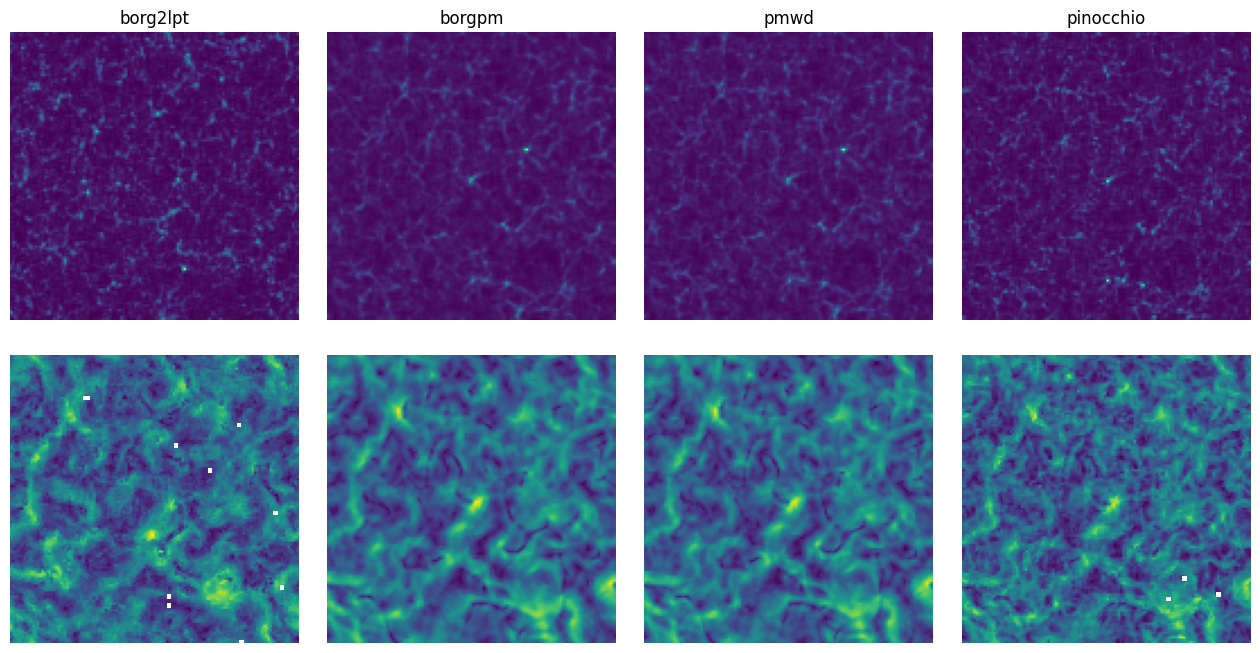

In [7]:
# temp
mlist = ['borg2lpt', 'borgpm', 'pmwd', 'pinocchio']

f, axs = plt.subplots(
    2,len(mlist), figsize=(4*len(mlist),8), 
    gridspec_kw=dict(hspace=0.1, wspace=0.1)
)

for i, m in enumerate(mlist):
    path = f"/home/mattho/git/ltu-cmass/data/test/{m}/L1000-N128/100"

    rho = np.load(join(path, 'rho.npy'))
    fvel = np.load(join(path, 'fvel.npy'))
    print(rho.std(), fvel.std())

    ax = axs[0,i]
    ax.imshow(rho[0])
    ax.axis('off')
    ax.set_title(m)

    ax = axs[1,i]
    ax.imshow(np.linalg.norm(fvel[0], axis=-1))
    ax.axis('off')


## Suite

In [19]:
from collections import Counter
suitepath = '/home/mattho/git/ltu-cmass/data/charm_1gpch_z0.5/borgpm/L1000-N128/'

c = Counter()
for r in tqdm(os.listdir(suitepath)):
    for k in os.listdir(join(suitepath, r)):
        c[k] += 1

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:00<00:00, 7550.41it/s]


In [20]:
cosmofile = '../params/latin_hypercube_params.txt'
cosmos = pd.read_csv(cosmofile, sep=' ', header=None).values
cosmos

array([[0.1755 , 0.06681, 0.7737 , 0.8849 , 0.6641 ],
       [0.2139 , 0.05557, 0.8599 , 0.9785 , 0.8619 ],
       [0.1867 , 0.04503, 0.6189 , 0.8307 , 0.7187 ],
       ...,
       [0.4017 , 0.04425, 0.8509 , 0.8251 , 0.7833 ],
       [0.2953 , 0.04701, 0.8017 , 0.8193 , 0.6627 ],
       [0.3175 , 0.049  , 0.6711 , 0.9624 , 0.834  ]])

In [21]:
# Load Pks
pks = np.zeros((len(cosmos), 399))
for r in tqdm(os.listdir(suitepath)):
    try:
        pk = np.load(join(suitepath, r, 'Pk', 'Pk0.npz'))
    except FileNotFoundError:
        continue
    k_gal = pk['k_gal']
    p0 = pk['p0k_gal']
    pks[int(r)] = p0

100%|██████████| 2000/2000 [00:01<00:00, 1723.72it/s]


In [22]:
cosmos[4]

array([0.1433 , 0.06347, 0.6127 , 1.1501 , 0.7699 ])

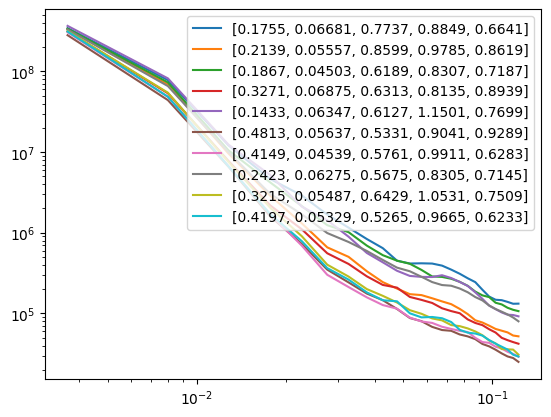

In [23]:
plt.loglog()

for i in range(10):
    plt.plot(k_gal, pks[i], label=f'{list(cosmos[i])}')
plt.legend()

## Inference

In [24]:
mask = np.all(pks==0, axis=1)
pks = pks[~mask]
cosmos = cosmos[~mask]

x = np.log10(pks[:2000,:25])
theta = cosmos[:2000]

In [25]:
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior
device='cuda'

In [26]:
loader = NumpyLoader(x=x, theta=theta)

# define a prior
prior = ili.utils.Uniform(
    low=theta.min(axis=0),
    high=theta.max(axis=0),
    device=device)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=50, num_transforms=5),
    ili.utils.load_nde_sbi(engine='NPE', model='mdn', hidden_features=50, num_components=6)
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-4
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=None,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [27]:
# train the model
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
INFO:root:Training model 1 / 2.


 Neural network successfully converged after 242 epochs.

INFO:root:Training model 2 / 2.


 Training neural network. Epochs trained: 114

/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/sbi/utils/posterior_ensemble.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights = torch.tensor(weights) / sum(weights)
INFO:root:It took 245.5884141921997 seconds to train models.


 Neural network successfully converged after 115 epochs.

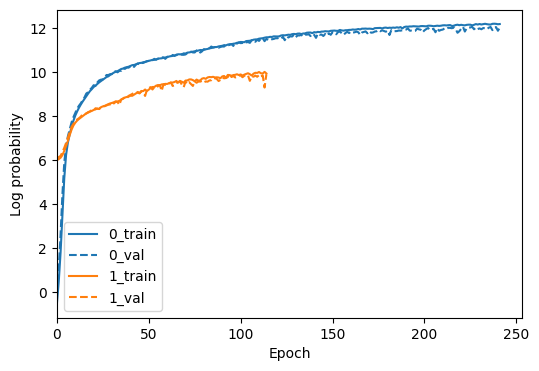

In [28]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = [f"C{i}" for i in range(len(summaries))]
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

Drawing 892 posterior samples:   0%|          | 0/892 [00:00<?, ?it/s]

Drawing 892 posterior samples: 934it [00:00, 47927.87it/s]            
Drawing 108 posterior samples: 157it [00:00, 48083.66it/s]            


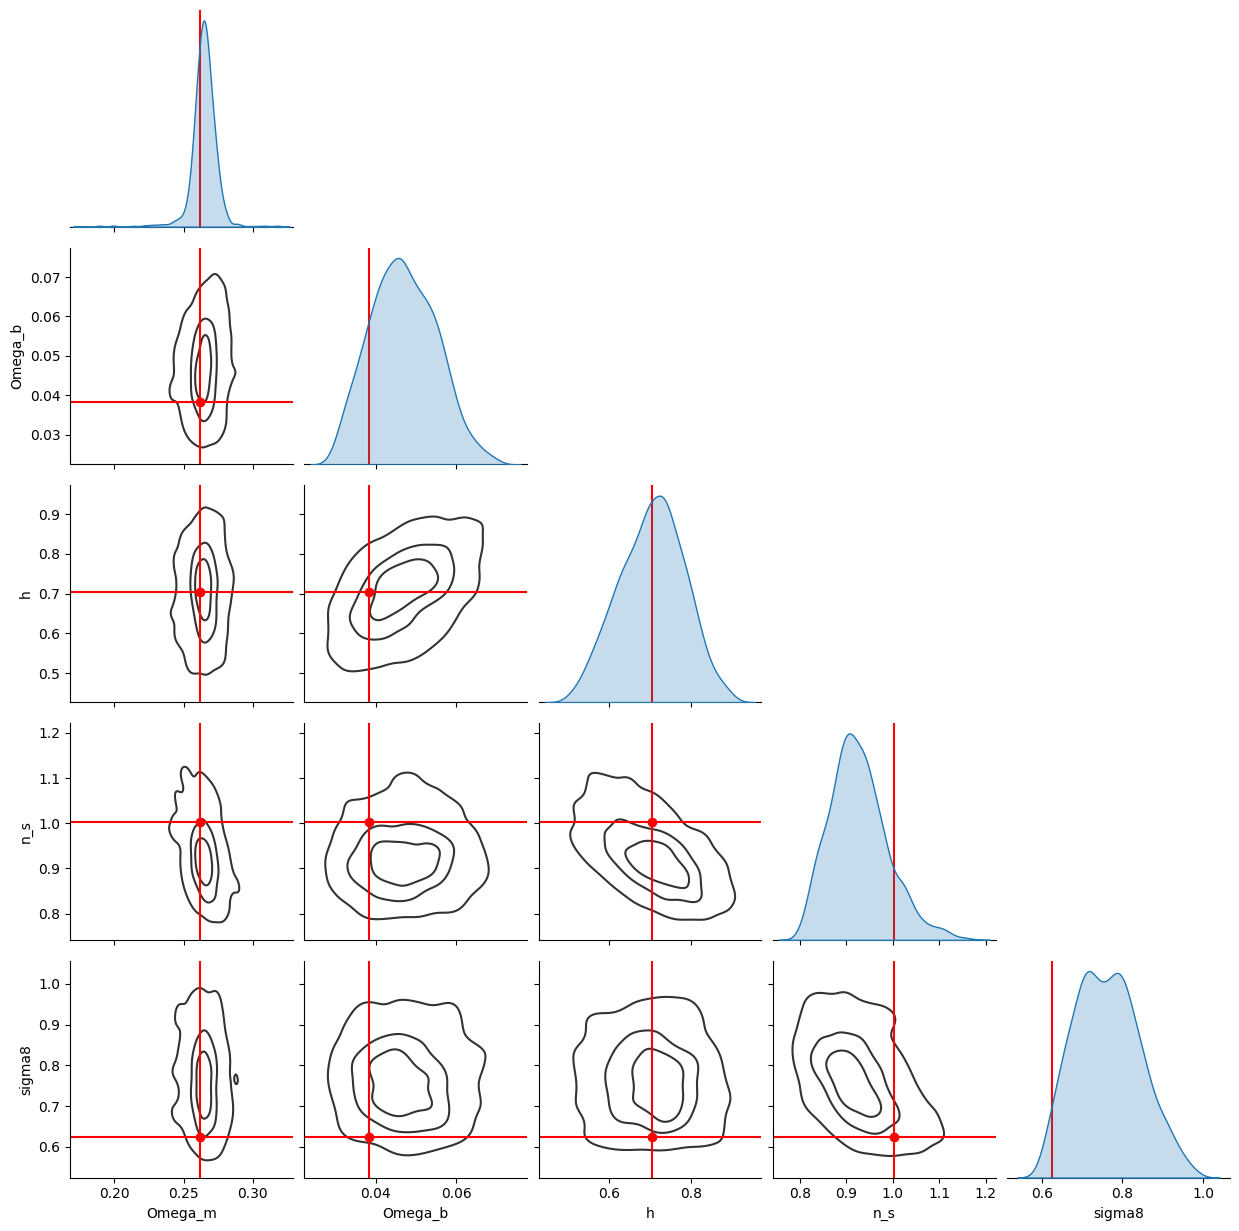

In [29]:
# choose a random input
seed_in = 49
np.random.seed(seed_in)
ind = np.random.randint(len(theta))

# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma8']
    # labels=[f'$\\theta_{i}$' for i in range(3)]
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = x[ind], theta_fid=theta[ind]
)

In [30]:
theta.min(axis=0), theta.max(axis=0)

(array([0.1001 , 0.03001, 0.5001 , 0.8001 , 0.6001 ]),
 array([0.4999 , 0.06999, 0.8999 , 1.1999 , 0.9999 ]))

  8%|▊         | 159/1999 [00:03<00:39, 46.28it/s]WARNING:root:Only 0.900% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    795 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
 32%|███▏      | 634/1999 [00:13<00:29, 46.55it/s]WARNING:root:Only 0.188% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    91 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
 47%|████▋     | 944/1999 [00:20<00:22, 46.58it/s]WARNING:root:Only 0.356% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    73 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
 95%|█████████▍| 1894/1999 [00:40<00:02, 4

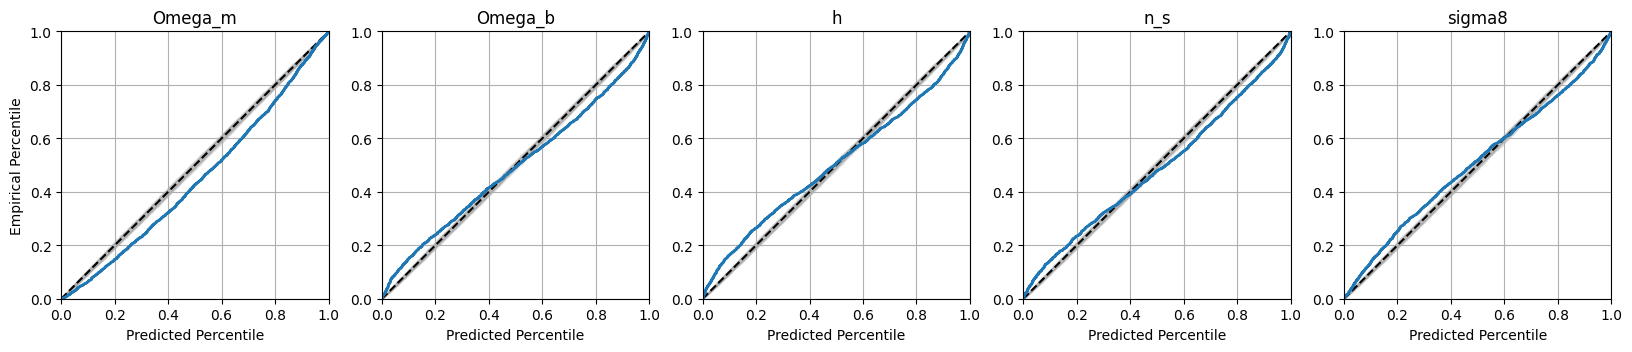

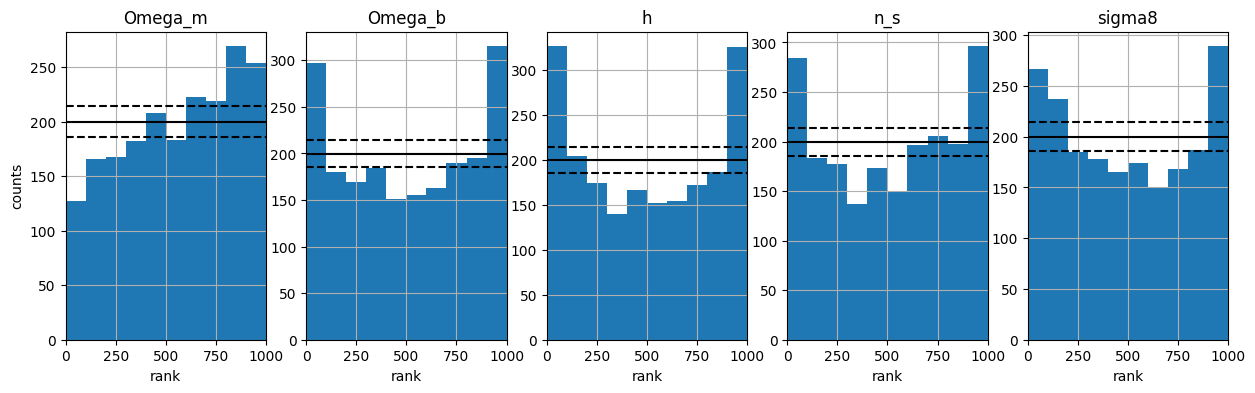

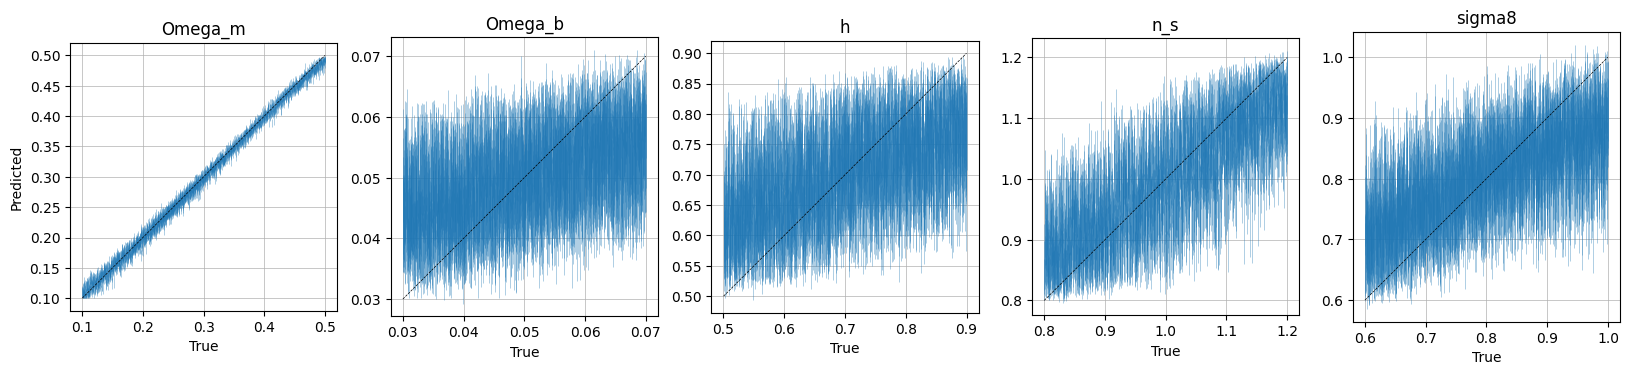

INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


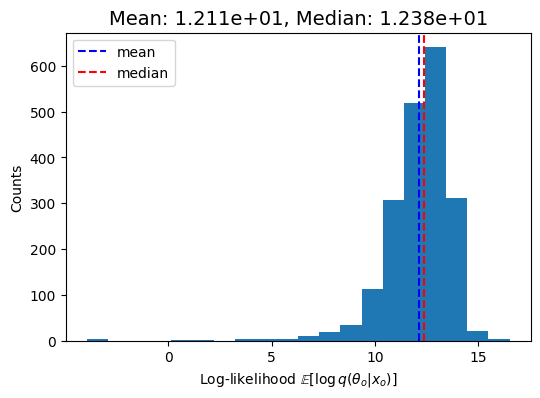

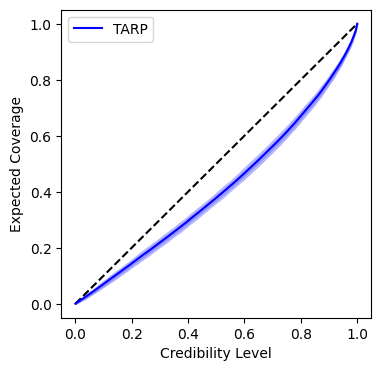

In [31]:
# Drawing samples from the ensemble posterior

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma8'],
    plot_list = ["coverage", "histogram", "predictions", "tarp", "logprob"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=x, theta=theta
)